# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [264]:
import numpy as np
import nltk
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [265]:
data = pd.read_csv('train.csv')

In [266]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [267]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [268]:
train.isna()
test.isna()

,id,keyword,location,text,target
2644,False,False,True,False,False
2227,False,False,True,False,False
5448,False,False,False,False,False
132,False,False,True,False,False
6845,False,False,False,False,False
...,...,...,...,...,...
4307,False,False,False,False,False
3375,False,False,False,False,False
1710,False,False,True,False,False
4898,False,False,False,False,False


In [269]:
train.fillna('', inplace=True)
test.fillna('', inplace=True)

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [270]:
train['target'].value_counts()

0    3024
1    2305
Name: target, dtype: int64

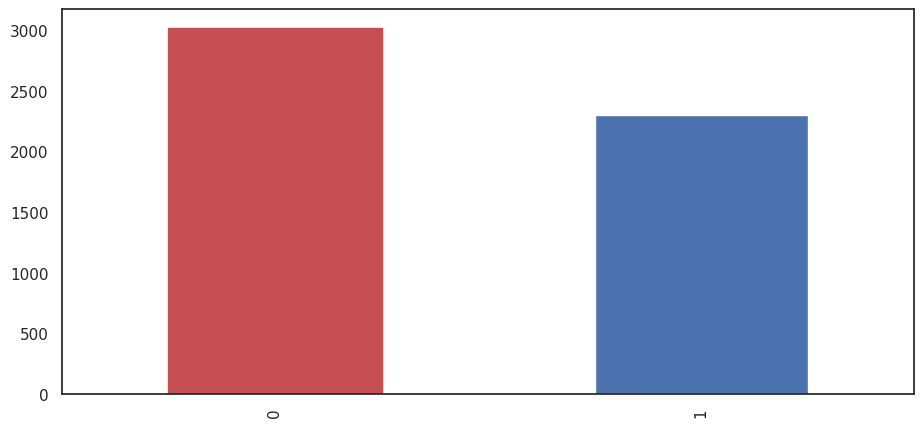

In [271]:
train['target'].value_counts().plot(kind='bar').get_children()[0].set_color('r') 

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

<AxesSubplot: xlabel='keyword', ylabel='Count'>

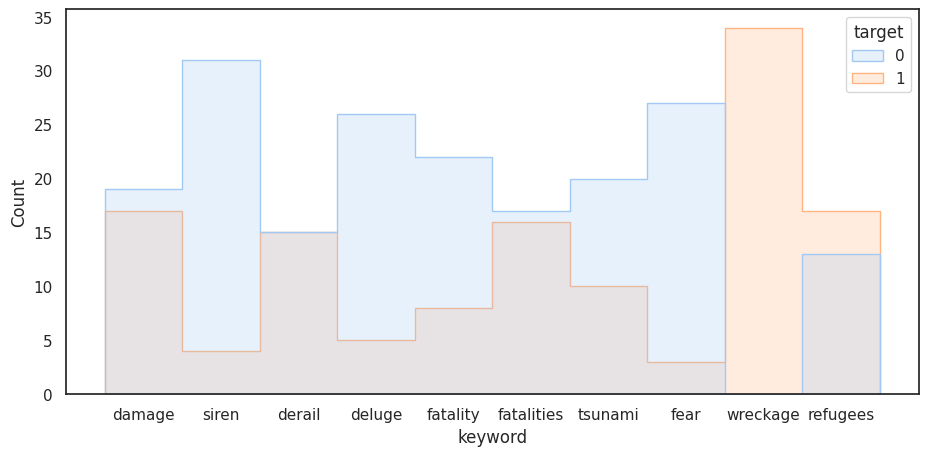

In [272]:
import seaborn as sns

popular_keywords = train['keyword'].value_counts()[1:11].index.to_list()
mask = train.keyword.isin(popular_keywords)
for_graph = train[mask]

sns.set(rc={'figure.figsize':(11, 5)})
sns.set_style("white")
#рисую сам график
sns.histplot(x='keyword', hue='target', data=for_graph, element="step", palette='pastel')

**Выводы**: среди 10 наиболее встречающихся значений, если мы не учитываем пустые строки, wreckage - тот тип катастрофы, информация о котором в твитах всегда настоящая, refugees - еще один тип, где твитов с настоящей информацией больше, в остальных типах количество твитов с неверной информацией выше, порой - значительно.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [273]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [274]:
train['text'] = train[['keyword', 'location', 'text']].agg(' '.join, axis=1)
train.pop('id')
train.pop('keyword')
train.pop('location')
train_new = train

In [275]:
test['text'] = test[['keyword', 'location', 'text']].agg(' '.join, axis=1)
test.pop('id')
test.pop('keyword')
test.pop('location')
test_new = test

In [276]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [277]:
from sklearn.feature_extraction.text import CountVectorizer
cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train_new['text'])
X

<5329x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 86671 stored elements in Compressed Sparse Row format>

Размер матрицы - 5329x18455

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [278]:
import re
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return (re.search(r'\d+', s) != None)

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return (re.search(r'[!\"#\$%&\'\(\)\*\+,-\.\/:;<=>\?@\[\]\^_`\{|\}~]', s) != None)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#')

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s.startswith('@')

def investigate_vocabulary(vocabulary):

    print('With digit:      ', sum(list(map(contains_digit, vocabulary.keys())))
          )
    print('With punctuation:', sum(list(map(contains_punctuation, vocabulary.keys())))
          )
    print('Hashtags:        ', sum(list(map(is_hashtag, vocabulary.keys())))
          )
    print('Mentions:        ', sum(list(map(is_mention, vocabulary.keys())))
          )




In [279]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [280]:
investigate_vocabulary(cnt_vec.vocabulary_
                       )

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [281]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
help(tt)
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

Help on TweetTokenizer in module nltk.tokenize.casual object:

class TweetTokenizer(nltk.tokenize.api.TokenizerI)
 |  TweetTokenizer(preserve_case=True, reduce_len=False, strip_handles=False, match_phone_numbers=True)
 |  
 |  Tokenizer for tweets.
 |  
 |      >>> from nltk.tokenize import TweetTokenizer
 |      >>> tknzr = TweetTokenizer()
 |      >>> s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
 |      >>> tknzr.tokenize(s0)
 |      ['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3'
 |      , 'and', 'some', 'arrows', '<', '>', '->', '<--']
 |  
 |  Examples using `strip_handles` and `reduce_len parameters`:
 |  
 |      >>> tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
 |      >>> s1 = '@remy: This is waaaaayyyy too much for you!!!!!!'
 |      >>> tknzr.tokenize(s1)
 |      [':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']
 |  
 |  Method resolution order:
 |      TweetTokenizer
 |      nltk.tok

In [282]:
cnt_vec_tok = CountVectorizer(tokenizer=tt.tokenize)
X_tok = cnt_vec_tok.fit_transform(train_new['text'])
X_tok 

<5329x19670 sparse matrix of type '<class 'numpy.int64'>'
	with 94563 stored elements in Compressed Sparse Row format>

In [283]:
investigate_vocabulary(cnt_vec_tok.vocabulary_
                       )

With digit:       3939
With punctuation: 7337
Hashtags:         1470
Mentions:         1679


**Сравнение:** можно сказать, что при использовании TweetTokenizer мы лучше справляемся с задачей, потому что он под эту задачу адаптирован, он позволяет нам сохранять хэштеги и упоминания людей, иначе работает с пунктуацией, оставляя ее внутри слов, и, как можно увидеть, за счет последнего у нас сохраняются адреса сайтов (и это может быть полезно при классификации твитов)

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру +
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk +
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы. +
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english') +
4. Проведет стемминг с помощью SnowballStemmer +



In [284]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
stopwords_list = nltk.corpus.stopwords.words('english') 

def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы  
    return (re.search(r'[^a-zA-Z]+', s) == None)

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return len(s) > 1 and (re.search(r'[^a-zA-Z]+', s) != None and ('(' in s or ')' in s))        

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#') and re.search(r'[^a-zA-Z]+', s[1:]) == None

def custom_tokenizer(s: str) -> List[str]:
    # Кастомный токенайзер
    tokens = tt.tokenize(s.lower())        
    return [stemmer.stem(w) for w in tokens if (contains_only_latin_letters(w) or is_emoji(w) or is_hashtag(w)) and not w in stopwords_list]
  

In [285]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [286]:
new_df = {}
new_df['before'] = train_new['text'][:10]
new_df['custom_tok'] = list(map(custom_tokenizer, train_new['text'][:10]))
show_res = pd.DataFrame(new_df)
show_res

/tmp/ipykernel_187/3515379755.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  new_df['before'] = train_new['text'][:10]
/tmp/ipykernel_187/3515379755.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  new_df['custom_tok'] = list(map(custom_tokenizer, train_new['text'][:10]))


,before,custom_tok
1186,bridge%20collapse Ashes 2015: AustraliaÛªs c...,"[bridg, ash, australia, collaps, trent, bridg,..."
4071,"hail Carol Stream, Illinois GREAT MICHIGAN TEC...","[hail, carol, stream, illinoi, great, michigan..."
5461,police Houston CNN: Tennessee movie theater s...,"[polic, houston, cnn, tennesse, movi, theater,..."
5787,rioting Still rioting in a couple of hours le...,"[riot, still, riot, coupl, hour, left, class]"
7445,wounds Lake Highlands Crack in the path where ...,"[wound, lake, highland, crack, path, wipe, mor..."
151,airplane%20accident Somewhere Out There Expert...,"[airplan, somewher, expert, franc, begin, exam..."
915,bloody Isolated City In World Perth 'I came to...,"[bloodi, isol, citi, world, perth, came, kill,..."
1305,burning @JohnsonTionne except idk them?? it's...,"[burn, except, idk, realli, burn]"
2570,destroy he/him or she/her (ask) destroy the house,"[destroy, ask, destroy, hous]"
7399,"wounded Maracay y Nirgua, Venezuela Police Off...","[wound, maracay, nirgua, venezuela, polic, off..."


## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [287]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer
                             )
X_train = vectorizer.fit_transform(train_new['text'])
X_test = vectorizer.transform(test_new['text'])

2. Обучите LogisticRegression на полученных признаках.


In [289]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, train_new['target'])
pred = clf.predict(X_test)

3. Посчитайте метрику f1-score на тестовых данных.

In [290]:
from sklearn.metrics import f1_score

print(f"F1 score: {f1_score(test_new['target'], pred)}")

F1 score: 0.7526881720430109


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [291]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1

vec = TfidfVectorizer(tokenizer=custom_tokenizer)
vec_train = vec.fit_transform(train_new['text'])
vec_test = vec.transform(test_new['text'])

clf = LogisticRegression()
clf.fit(vec_train, train_new['target'])
pred_tfidf = clf.predict(vec_test)

print(f"F1 score: {f1_score(test_new['target'], pred_tfidf)}")

F1 score: 0.7437465258476932


In [292]:
vec_train

<5329x10482 sparse matrix of type '<class 'numpy.float64'>'
	with 50511 stored elements in Compressed Sparse Row format>

1. **Ответ:** качество стало ниже, tf-idf векторизатор справляется с задачей хуже

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [293]:
# 2

vec = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
vec_train = vec.fit_transform(train_new['text'])
vec_test = vec.transform(test_new['text'])

clf = LogisticRegression()
clf.fit(vec_train, train_new['target'])
pred_tfidf = clf.predict(vec_test)

print(f"F1 score: {f1_score(test_new['target'], pred_tfidf)}")

F1 score: 0.7437465258476932


In [294]:
vec_train

<5329x10482 sparse matrix of type '<class 'numpy.float64'>'
	with 50511 stored elements in Compressed Sparse Row format>

2. **Ответ:** размер матрицы и качество не изменились, вероятнее всего, у нас нет большого количества значений df, выше 0.9, поэтому и результат остается прежним

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [295]:
# 3
vec = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=0.001)
vec_train = vec.fit_transform(train_new['text'])
vec_test = vec.transform(test_new['text'])

clf = LogisticRegression()
clf.fit(vec_train, train_new['target'])
pred_tfidf = clf.predict(vec_test)

print(f"F1 score: {f1_score(test_new['target'], pred_tfidf)}")

F1 score: 0.7457440966501921


3. **Ответ:** да, при значении min_df=0.001 получается улучшить значение на несколько тысячных долей

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [297]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
vec_train = vectorizer.fit_transform(train_new['text'])
vec_test = vectorizer.transform(test_new['text'])

clf = LogisticRegression()
clf.fit(vec_train, train_new['target'])
pred_tfidf = clf.predict(vec_test)

print(f"F1 score: {f1_score(test_new['target'], pred_tfidf)}")

/home/arinkazam/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7194645844952593


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Вообще в HashingVectorizer лучше поставить значение n_features=20000, тогда f1 будет повыше (0.7356705620478576), но все равно хуже, чем в предыдущих подходах. Самый высокий результат показывает подход с CountVectorizer, чуть хуже, но относительно высокий - TfidfVectorizer с параметром min_df=0.001.

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [298]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.tokenize import word_tokenize
stopwords_list = nltk.corpus.stopwords.words('english') 

def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return (re.search(r'[^a-zA-Z]+', s) == None)

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return len(s) > 1 and (re.search(r'[^a-zA-Z]+', s) != None and ('(' in s or ')' in s))       

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#') and re.search(r'[^a-zA-Z]+', s[1:]) == None

def custom_tokenizer(s: str) -> List[str]:
    # Кастомный токенайзер
    tokens = word_tokenize(s.lower())        
    return [stemmer.stem(w) for w in tokens if (contains_only_latin_letters(w) or is_emoji(w) or is_hashtag(w)) and not w in stopwords_list]
  

In [299]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer
                             )
X_train = vectorizer.fit_transform(train_new['text'])
X_test = vectorizer.transform(test_new['text'])

clf = LogisticRegression()
clf.fit(X_train, train_new['target'])
pred = clf.predict(X_test)

print(f"F1 score: {f1_score(test_new['target'], pred)}")

F1 score: 0.7531064289573204
